In [1]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from my_lib.layers import SoftmaxWithLoss, Affine, Relu
from my_lib.trainer import Trainer

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [3]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
col1.shape

(9, 75)

In [4]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
col2.shape

(90, 75)

In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

In [6]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = np.argmax(col, axis=1)
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [7]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + (2 * filter_pad)) \
                            / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], 
                                                                 filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = {}
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], 
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        acc = 0.0        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    
    def save_params(self, path='params.pkl'):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(path, 'wb') as f:
            pickle.dump(params, f)
        print("Save network parameters")
            
    def load_params(self, path='params.pkl'):
        with open(path, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i + 1)]
            self.layers[key].b = self.params['b' + str(i + 1)]
        print("Load network parameters")

In [8]:
(x_train, y_train), (x_test, y_test) = load_mnist(flatten=False)

x_train, y_train = x_train[:15000], y_train[:15000]
x_test, y_test = x_test[:3000], y_test[:3000]

In [9]:
max_epochs = 20

net = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                    hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(net, x_train, y_train, x_test, y_test, epochs=max_epochs, batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001}, 
                  eval_sample_num_per_epoch=1000, verbose=1)

In [10]:
trainer.train()

Epoch : 1, train acc : 0.12600, test acc : 0.15600
Epoch : 2, train acc : 0.89100, test acc : 0.87600
Epoch : 3, train acc : 0.93500, test acc : 0.92300
Epoch : 4, train acc : 0.94500, test acc : 0.93900
Epoch : 5, train acc : 0.96500, test acc : 0.95300
Epoch : 6, train acc : 0.97500, test acc : 0.96500
Epoch : 7, train acc : 0.97700, test acc : 0.97100
Epoch : 8, train acc : 0.98400, test acc : 0.97200
Epoch : 9, train acc : 0.98300, test acc : 0.97000
Epoch : 10, train acc : 0.98700, test acc : 0.97300
Epoch : 11, train acc : 0.98800, test acc : 0.97700
Epoch : 12, train acc : 0.98600, test acc : 0.98000
Epoch : 13, train acc : 0.99400, test acc : 0.97900
Epoch : 14, train acc : 0.99000, test acc : 0.98000
Epoch : 15, train acc : 0.99000, test acc : 0.97100
Epoch : 16, train acc : 0.99200, test acc : 0.97200
Epoch : 17, train acc : 0.99900, test acc : 0.97800
Epoch : 18, train acc : 0.99700, test acc : 0.98100
Epoch : 19, train acc : 0.99800, test acc : 0.98100
Epoch : 20, train acc

In [11]:
net.save_params('params.pkl')

Save network parameters


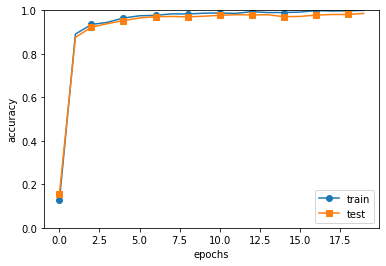

In [12]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()